## Lab 5 Part II: Plotting Contoured Upper-Air Data
<br /><br />

In this part of the tutorial, we are going to plot station data (observations) at 500 hPa and GFS model-derived 500 hPa geopotential height isopleths.
<br />
### Module Documentation

1. Siphon IAStateUpperAir: https://unidata.github.io/siphon/latest/api/simplewebservice.html#module-siphon.simplewebservice.iastate
2. Xarray Dataset: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html
3. Matplotlib Pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
4. Caropy crs: https://scitools.org.uk/cartopy/docs/latest/reference/crs.html
5. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
6. Matplotlib Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
7. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
8. Matplotlib Barbs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barbs.html
9. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html



If you have any questions about the code below, feel free to reach out to me at mpvossen@uwm.edu. I am always willing to further explain the code. <br /> <br />

---

<br />
1. As usual, we start by importing the modules we need for our Python code.

In [1]:
#from the dates and time code(datetime), import the date and time reading capabilities (datetime)
from datetime import datetime

#from the metpy (metpy) module's ability to read and write files (.io), import the function to add latitude and longitude data for upper-air and surface station data (import add_station_lat_lon)
from metpy.io import add_station_lat_lon

#from metpy's plotting abilities (metpy.plots), import the abilities to create a station plot (StationPlot) and the sky cover symbols (sky_cover).
from metpy.plots import StationPlot, sky_cover

#import the module numpy and save it to np
import numpy as np

#import the cartopy (cartopy) module's coordinate reference system (.crs) and save it to the variable crs
import cartopy.crs as crs

#import the cartopy (cartopy) module's ability to plot geographic data (.feature) and save it to the variable cfeature 
import cartopy.feature as cfeature

#import the pyplot submodule from the matplotlib module
import matplotlib.pyplot as plt

#from the scipy module's ndimage submodule, import the function gaussian_filter
from scipy.ndimage import gaussian_filter

#import the module xarray and save it to xr
import xarray as xr

#from the siphon module's (from siphon) web data downloader (.simplewebservice) specifically for Iowa State (.iastate) data, import the upper air downloader (import IAStateUpperAir)
from siphon.simplewebservice.iastate import IAStateUpperAir

#import the sys module to tap into the underlying Linux operating system
import sys

#One of our modules is not in the standard location, so we need to define the location of the Extra_Modules directory where there are some homemade modules.
sys.path.insert(0, '/srv/data/shared_notebooks/Synoptic1-AtmSci360/Extra_Modules/')

#from the module min_max (available through the module path defined above), import the function plot_maxmin_points
from min_max import plot_maxmin_points

<br /><br />
2.  We need to set up two variables, one for the time at which we want data and the other for the isobaric level at which we want data (in hPa).  In the section below, define a datetime object for August 30th, 2021 1200 UTC and a variable containing the desired isobaric level (here, 500 hPa).

In [2]:
map_time = datetime(2021,8,30,12)
level = 500

<br /><br />
3. We again process the data in a function since we will be creating multiple plots.  Watch out in the comments for areas that you need to fill in or complete.

In [3]:
"""
Below I define a function to retrieve and process upper-air data.  This function downloads rawinsonde data, opens the corresponding
GFS analysis data, retains only the desired pressure level, and removes missing values from the rawinsonde data.


INPUT:
    level : INTEGER
        The level in hPa at which you want upper-air data.
    time : DATETIME
        The time at which you would like upper-air data.
    
OUTPUT:
    obs_data : PANDAS DATAFRAME
        Dataframe containing your processed rawinsonde data
    leveled_data : XARRAY DATASET
        The xarray containing your processed GFS analysis data

"""

def process_upper_air_data(level, time):
    """
    Specify the location of the upper-air data on the JupyterHub.
    """
    lab_data_loc = "/data/AtmSci360/Lab_5/"
    
    """
    Open the GFS data using xarray.  Since the data are once again GRIB-formatted data, we can use xarray the same way we did in Lab 4.
    """
    model_data = xr.open_dataset(f"{lab_data_loc}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    
    """
    We only want data at a single isobaric level.  Limit the data in the xarray to only this specified level.
    """
    leveled_data = model_data.sel(isobaricInhPa = level)
    
    """
    We also need upper-air observations, so let's download rawinsonde data from Iowa State for the single specified level, as we did in Lab 2.
    """
    obs_data = IAStateUpperAir.request_all_data(map_time, level)
    
    """
    Like in Lab 2, the downloaded Iowa State rawinsonde data do not have latitude and longitude information for each station.  
    The line below adds the latitude and longitude to each station using MetPy's add_stations_lat_lon function.
    """
    obs_data = add_station_lat_lon(obs_data)
    
    
    """
    The MetPy add_station_lat_lon does not have every station, however, and so some stations are missing their latitude and 
    longitude values.  The command below drops all stations that do not have a latitude and/or longitude value.
    """
    obs_data = obs_data.dropna(how='any', subset=['latitude', 'longitude'])
    
    
    """
    This line returns the observation data and model data after the function ends.
    """
    return obs_data, leveled_data

<br /><br />
4. In the cell below, call the function we created to process data using the level and time you specified earlier in this lab.

In [4]:
obs_data,leveled_data=process_upper_air_data(level, map_time)

Ignoring index file '/data/AtmSci360/Lab_5/083021_12_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850

<br /><br />
5. Since we are making multiple plots, we also need to create a plot function.  Again, watch out in the comments for areas that you need to fill in or complete.

In [5]:
"""
Below I define a function to plot upper-air data.  This function creates station-model plots for the observations and
uses GFS data to draw geopotential height isopleths.


INPUT:
    obs_data : PANDAS DATAFRAME
        The dataframe containg your rawinsonde data
    model_data : XARRAY DATASET
        The xarray dataset containing your GFS analysis.
    date : DATETIME
        The time at which your upper-air data are valid.
    level : INTEGER
        The level in hPa at which you want upper-air data.
    
"""


def plot_upper_air(obs_data, model_data, date, level):
    
    """
    Setup a Lambert Conformal Conic Projection centered at 35°N and 95°W.  Have the cone of the Lambert Conformal Conic projection intersect the Earth at 27.5°N and 42.5°N.
    """
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
    
    
    """
    Create a figure with a size of 1000px x 1500px and a resolution of 300 dots per inch,
    then set up an axes object (named ax) using the projection we previously defined for our map.
    """
    fig = plt.figure(figsize=(10,15),dpi=300)
    
    ax = plt.subplot(projection = proj)
    
    
    
    """
    Add the appropriate amount of geographic data.  Be sure you follow "good map" suggestions with the geographic data styling.
    """
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)

    
    
    """
    Limit the map to between 125°-65°W longitude and 23°-60°N latitude.
    """
    ax.set_extent((-125, -65, 23, 60))
    
    """
    Setup the station plots for the upper-air observations.
    """
    stationplot = StationPlot(ax, obs_data['longitude'].values, obs_data['latitude'].values,
                          clip_on=True, transform=crs.PlateCarree(), fontsize=6)
    
    """
    Add temperature, dewpoint, wind, and geopotential height (in decameters) in the appropriate locations with appropriate formatting.  
    Make sure that your data displayed in your station plot are clear and easy to read.
    """
    stationplot.plot_parameter('NW', obs_data['temperature'].values, color='red')
    stationplot.plot_parameter('SW', obs_data["dewpoint"].values,color='darkgreen')
    stationplot.plot_parameter('NE', obs_data['height'].values, color='black')
    stationplot.plot_barb(obs_data['u_wind'].values, obs_data['v_wind'].values)

    

    
    """
    Like in Lab 2, we need to make the center sky cover symbol an open circle.  MetPy's sky_cover function produces this symbol when the sky cover value
    is zero.  Here, I create a list of zeros, one for each station, and then I pass it into the plot_symbol function to get
    the open circle center symbol.
    """
    num_of_stations = len(obs_data["latitude"].values)

    zeros = np.zeros(num_of_stations, dtype=int)
    
    stationplot.plot_symbol('C', zeros, sky_cover)
    


    
    """
    Switching to the GFS analysis, first we want to smooth the geopotential height data to make them easier to analyze.  
    Setup the Gaussian filter for the geopotential heights ('gh'). Choose an appropriate smoothing value for these data.
    """
    smooth_heights = gaussian_filter(model_data["gh"].values,2)
    
    
    """
    We can now isopleth the smoothed geopotential height data.  In the statement below, add styling information to make the contours easier to read.
    """
    cont_p = plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,10000,60),linewidths = 0.5,colors='k', transform=crs.PlateCarree())
    
    
    """
    Every contour plot needs labels for each contour, so we add contour labels below.  Add styling information to make the contour labels easier to read.
    """
    ax.clabel(cont_p, cont_p.levels, fmt=lambda v: format(v, '.0f'),fontsize=6)
     

    """
    Let's add symbols denoting minima (lows) and maxima (highs) in the gridded geopotential height data.
    The function below takes our gridded data, find the minimum and maximum points, and then plots
    the appropriate symbol with the value.
    
    The first argument is our axes variable.
    The second and third arguments are our longitude and latitude variables, respectively.
    The fourth argument is our gridded geopotential height data.
    The fifth argument says if we are looking for lows (min) or highs (max).
    The sixth argument says how much of a spatial buffer to use when searching for highs and lows.  The function will be more sensitive to smaller-
    scale highs and lows (thus leading to more highs and lows being plotted) when this value is smaller. The opposite is true when this value is larger.
    You will have to experiment with different values to find one that displays the appropriate amount of highs and lows (i.e., reflecting synoptic-scale
    features) rather than every high and low point in the data.
    The seventh argument is the size of the high or low symbols.
    The final argument is the data's coordinate system.
    """                  
    plot_maxmin_points(ax, model_data["longitude"].values, model_data["latitude"].values, smooth_heights, "min", 25, textsize=20, transform=crs.PlateCarree())
    plot_maxmin_points(ax, model_data["longitude"].values, model_data["latitude"].values, smooth_heights, "max", 25, textsize=20, transform=crs.PlateCarree())
    
              
    """
    Finally, add an appropriate title for the map that shows what is plotted and the time at which the map is valid.
    """
              
    plt.title(f"Valid: {map_time:%m/%d/%Y %H%M} UTC", size=7, loc="right")
    plt.title(f"500hpa Oberservations, Geopotential Height (black| dm)",size=9,weight="bold",loc="left")

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iterati

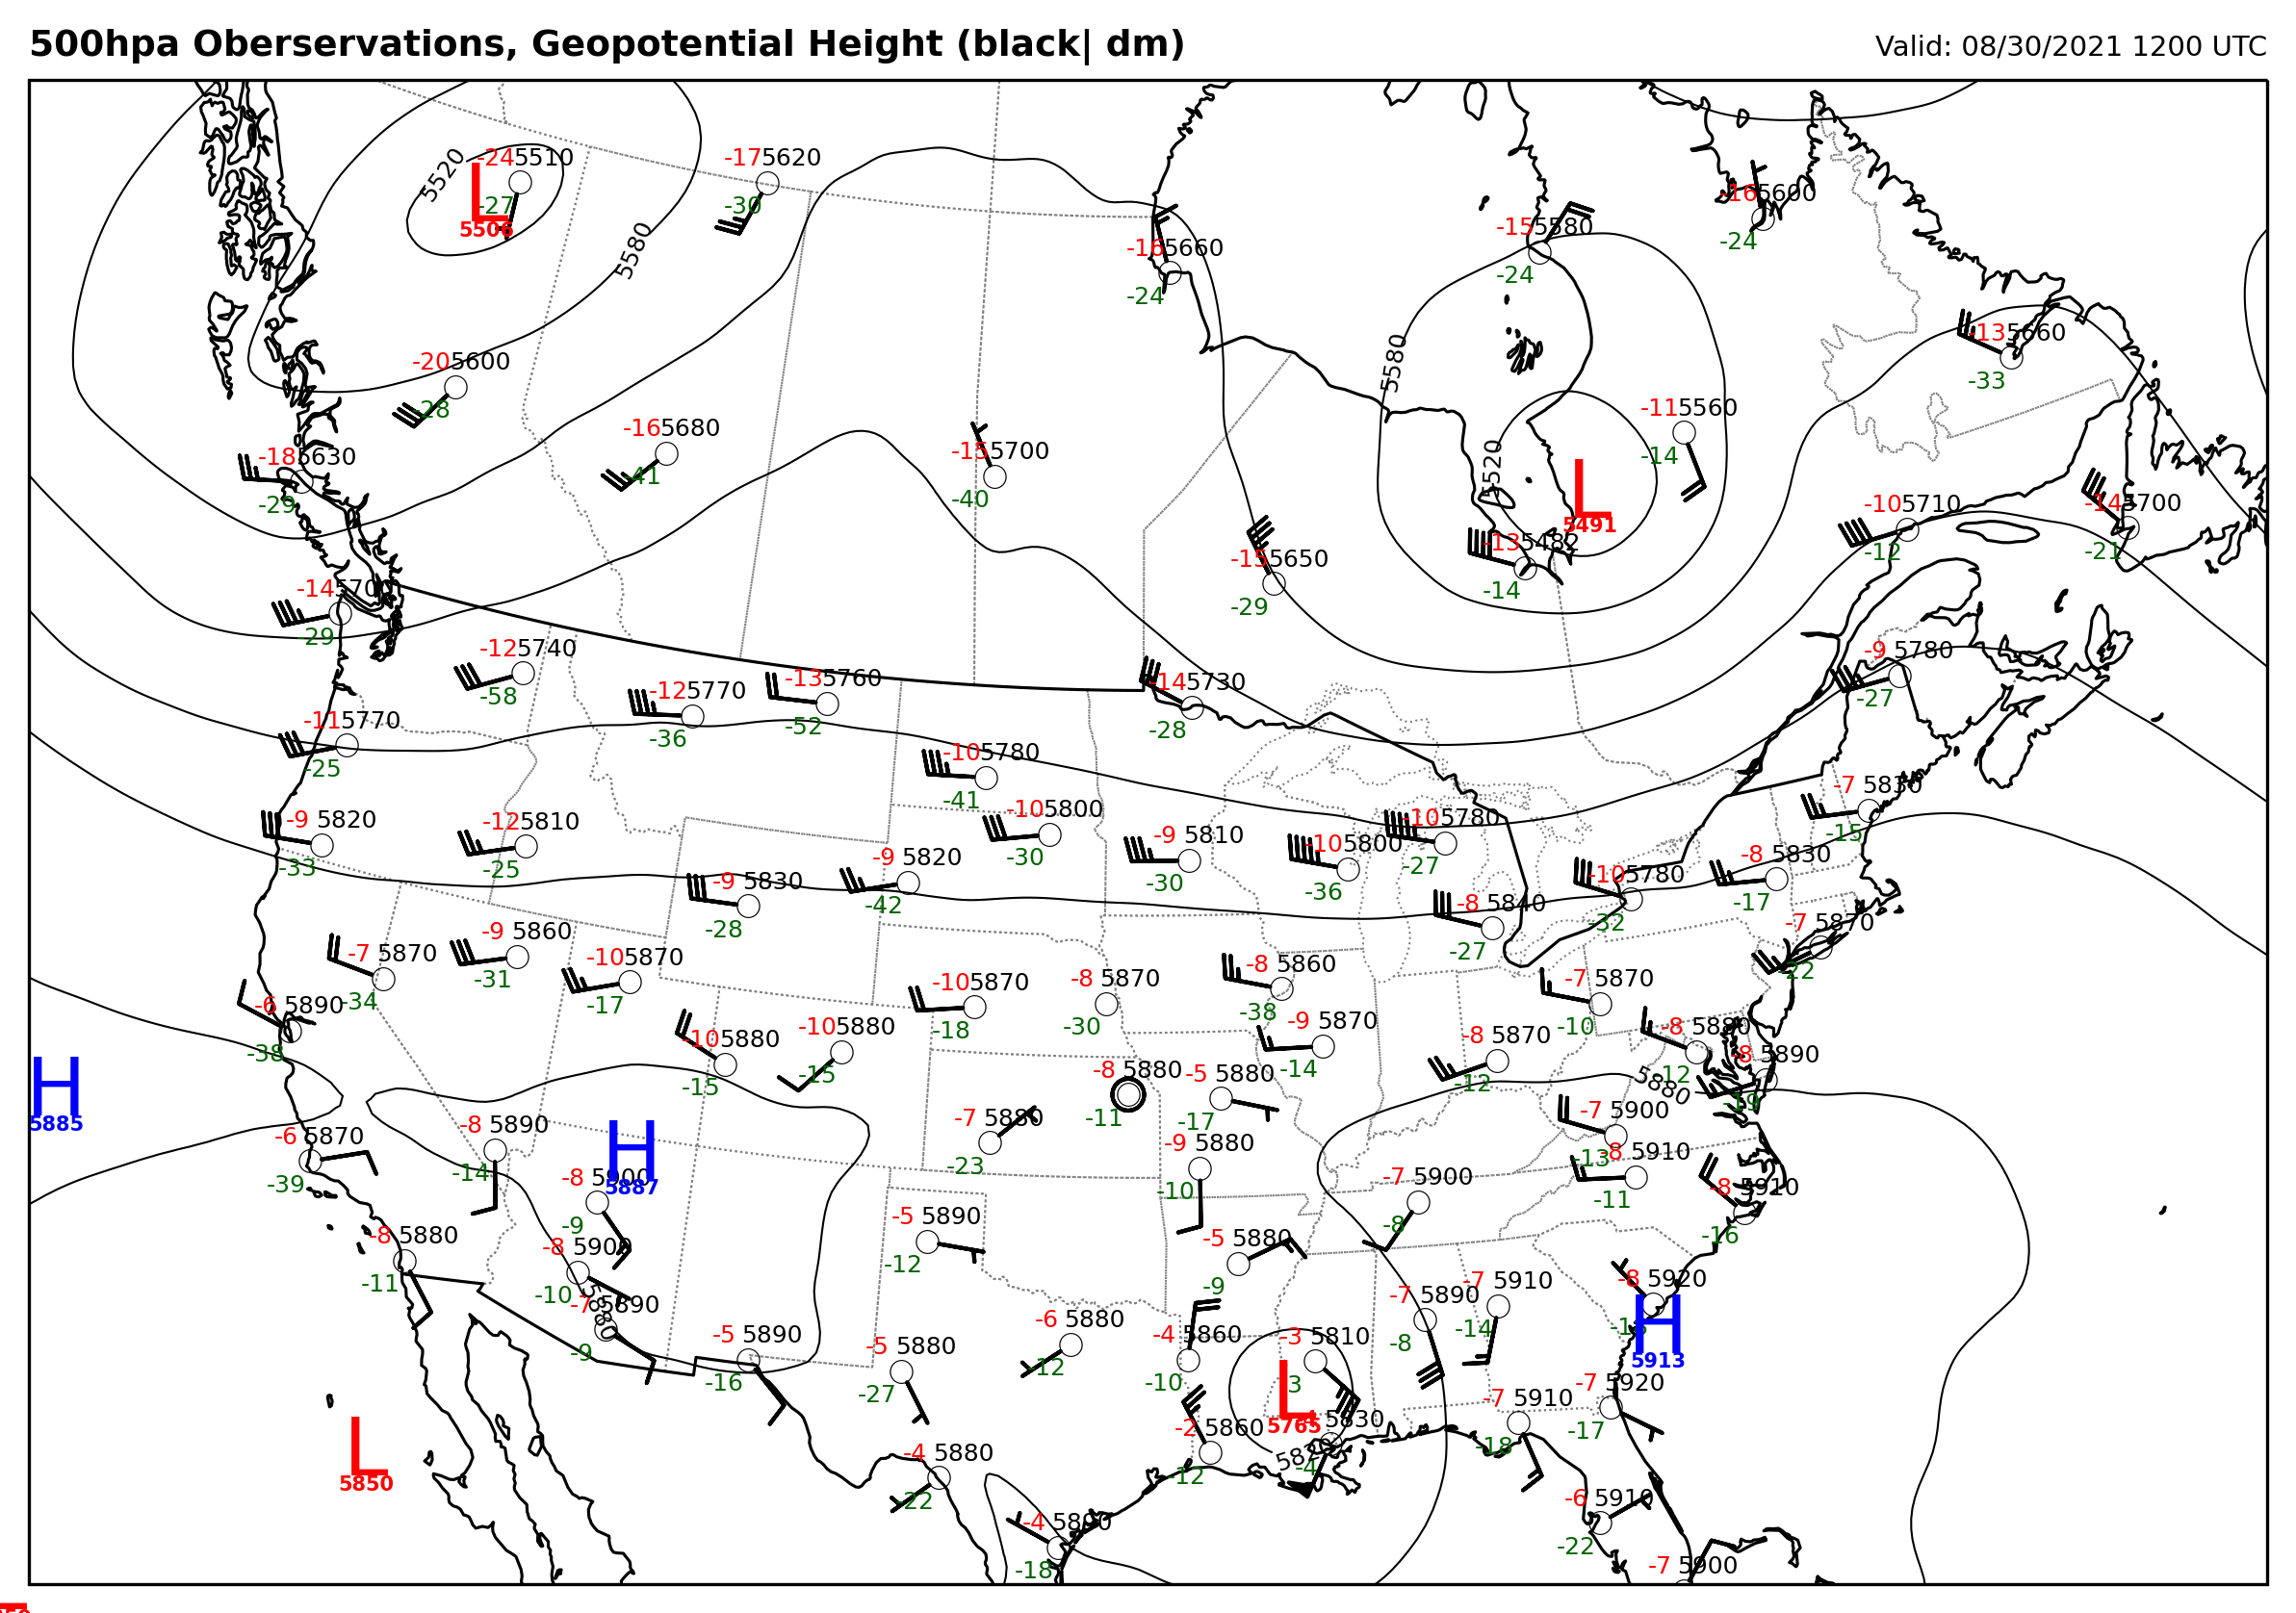

In [6]:
plot_upper_air(obs_data, leveled_data, map_time, level)

<br /><br />
6. Finally, re-run the two functions we created to create a plot valid at 1200 UTC on July 28th, 2022.

Can't create file '/data/AtmSci360/Lab_5/072822_00_gfs.grib2.923a8.idx'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 522, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/opt/tljh/user/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 488, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: '/data/AtmSci360/Lab_5/072822_00_gfs.grib2.923a8.idx'
Can't read index file '/data/AtmSci360/Lab_5/072822_00_gfs.grib2.923a8.idx'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 532, in from_indexpath_or_filestream
    index_mtime = os.path.getmtime(indexpath)
  File "/opt/tljh/user/lib/python3.7/genericpath.py", line 55, in getmti

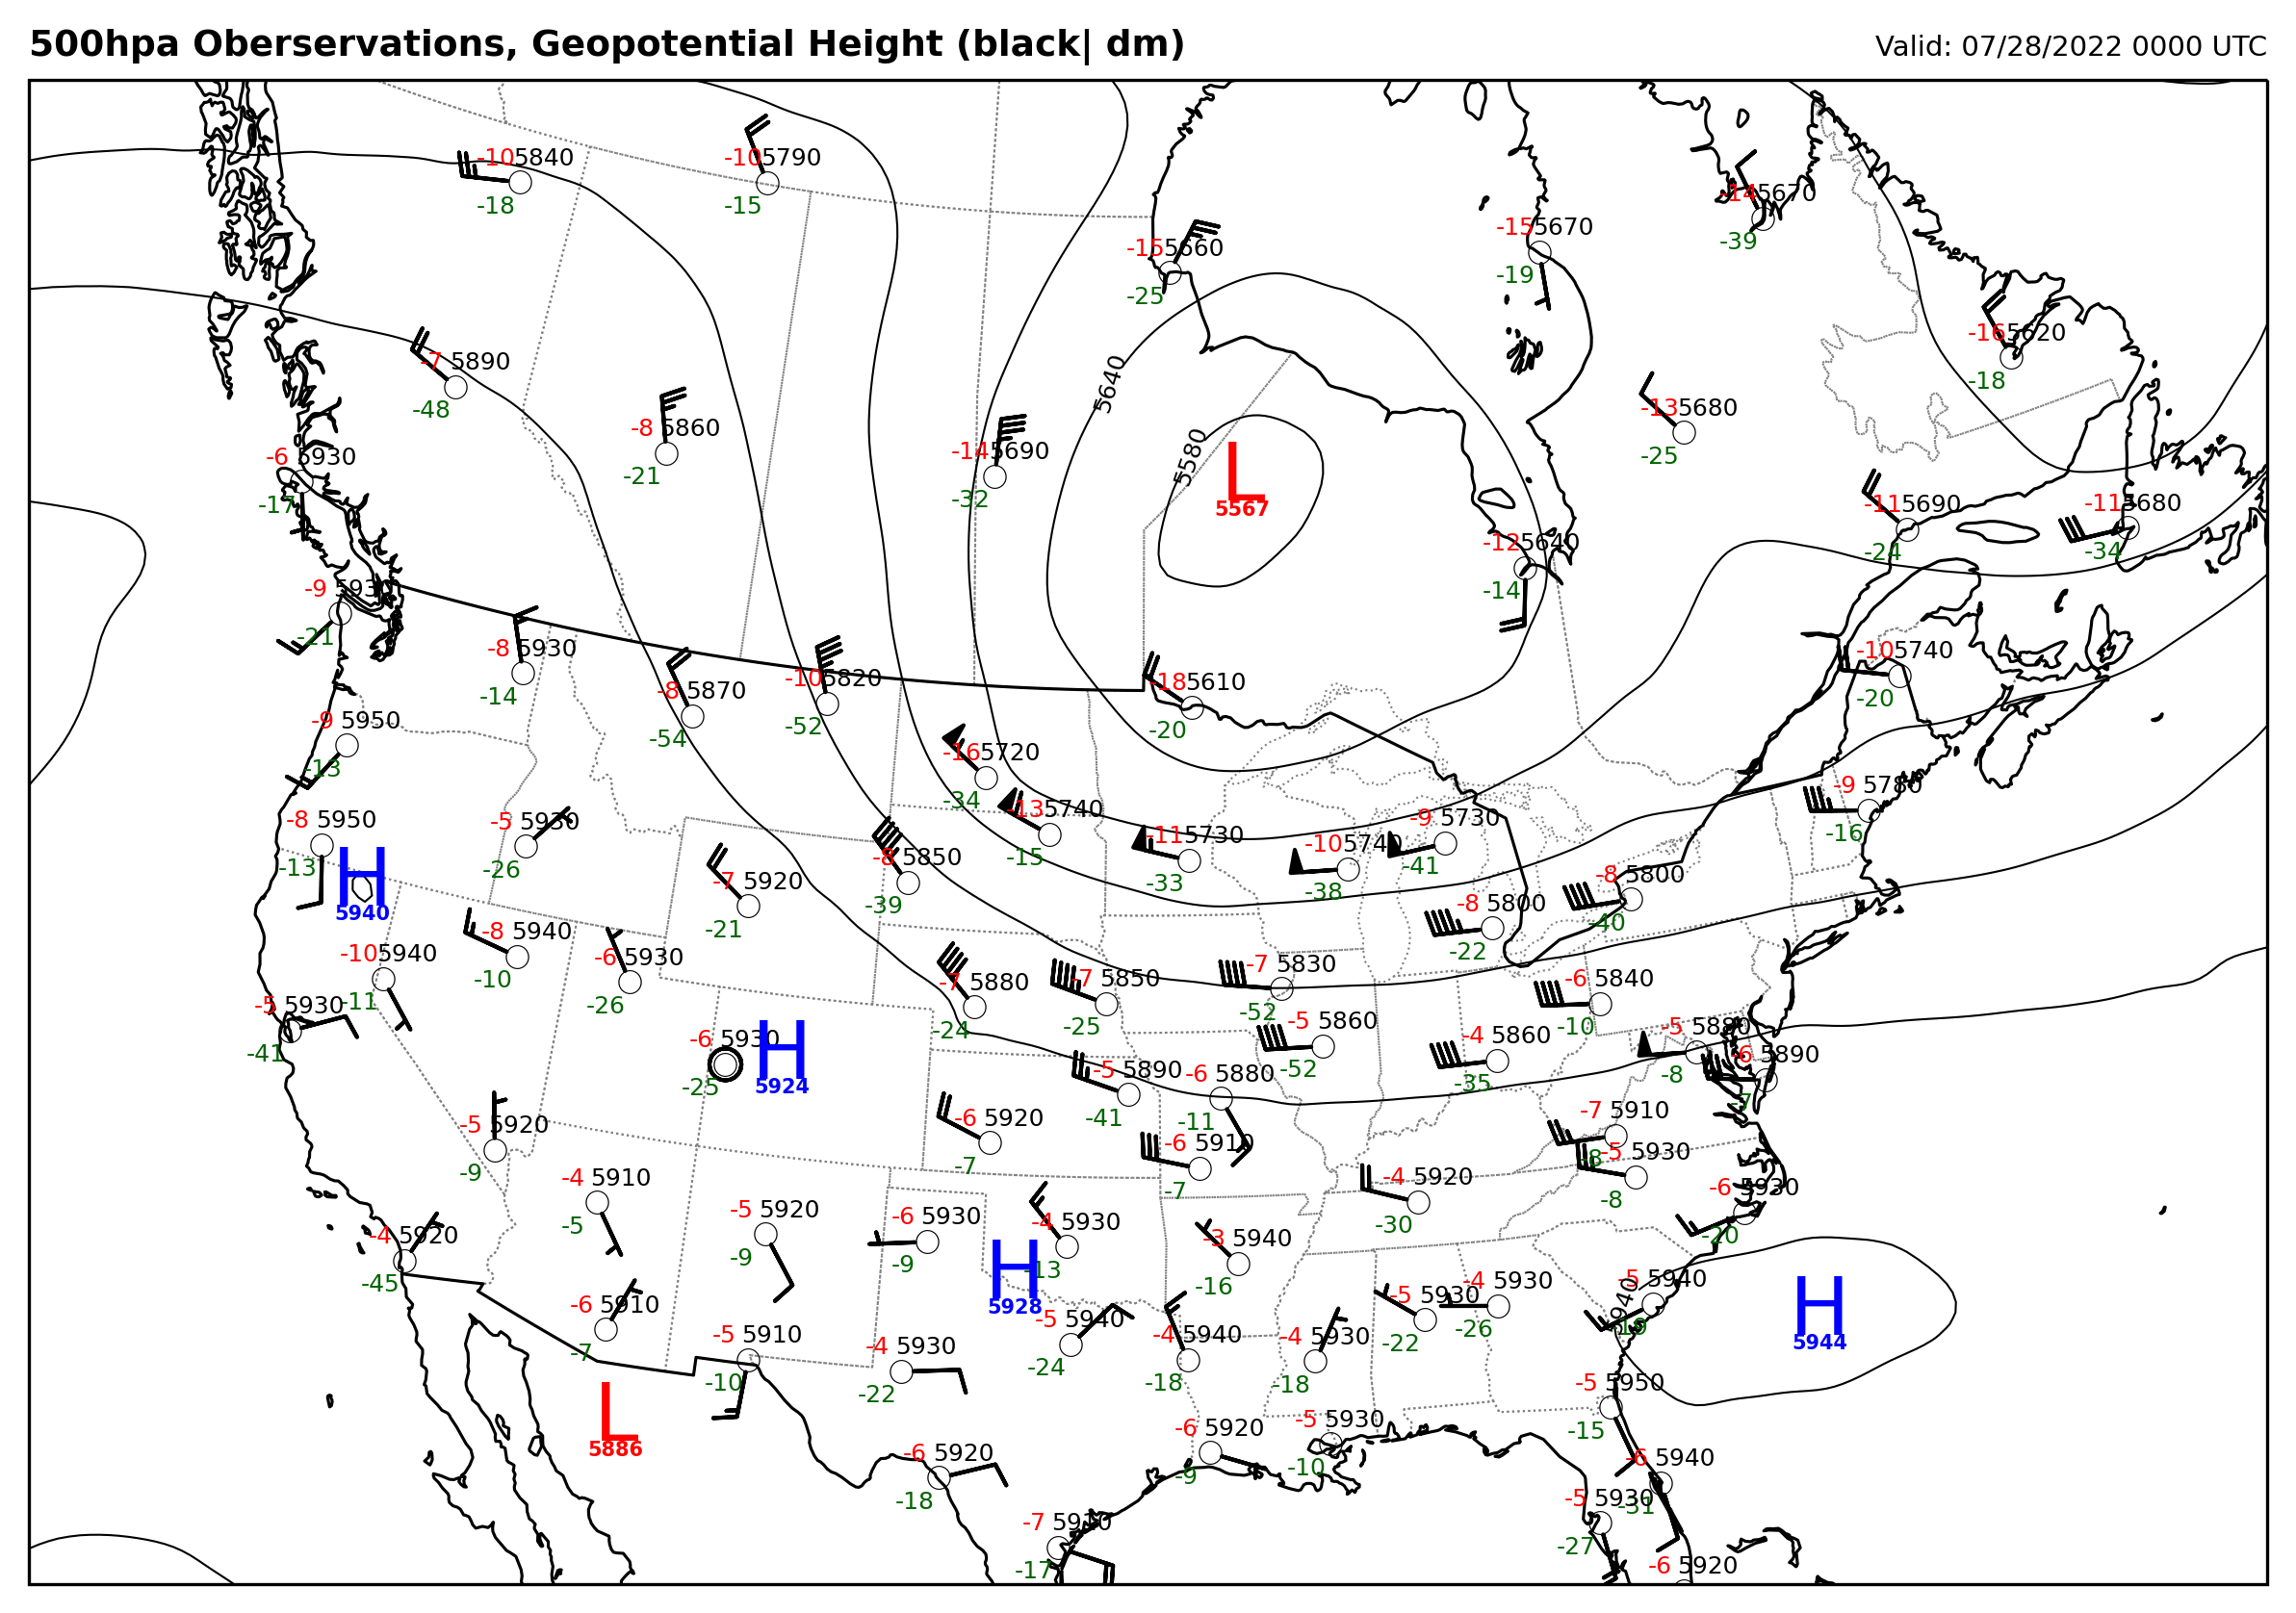

In [7]:
map_time = datetime(2022,7,28,0)
obs_data,leveled_data=process_upper_air_data(level, map_time)

plot_upper_air(obs_data, leveled_data, map_time, level)

### You have now completed the Python portion of the lab.  Be sure to submit the fully rendered Jupyter Notebook on GitHub when you are finished.